In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Lib.module.risk_budgeting import *
import student_mixture as sm

In [3]:
np.random.seed(0)

In [4]:
### Import stock price data for model calibration
freq = 'B'
assets = ['JPM UN Equity', 'PFE UN Equity', 'XOM UN Equity']
nb_asset = len(assets)

df_all = pd.concat([pd.read_excel('Data/SP_RC.xlsx',index_col=0, header=[0,1]), pd.read_excel('Data/SP_RC2.xlsx',index_col=0, header=[0,1])])
df_all = df_all.dropna(how='all').dropna(axis=1)
df_all = df_all.pct_change().dropna()
df_all = df_all.replace([np.inf, -np.inf], np.nan)
df_all = df_all[~df_all.index.duplicated(keep='first')]
df = df_all[assets]

X = df.values

In [5]:
X.shape

(3446, 3)

In [6]:
### Fit Student-t mixture (2 components) to chosen stock returns
n_sm = 2
SM_model = sm.StudentMixture(n_components=n_sm).fit(X)

locs = SM_model.locations_
scales = SM_model.scales_
probs = SM_model.weights_
dofs = SM_model.dofs_

### Some adjustments on the parameters of the final model 
locs = np.array([round_to_1(i) for i in locs.flatten()]).reshape(locs.shape)
scales = np.array([round_to_1(i) for i in scales.flatten()]).reshape(scales.shape)

dofs[0] = round_down(dofs[0], 1)
dofs[1] = round_down(dofs[1], 1)

probs[0] = round_up(probs[0], 1)
probs[1] = 1-probs[0]


SM_model.locations_ = locs
SM_model.scales_ = scales
SM_model.weights_ = probs
SM_model.dofs_ = dofs

In [7]:
### Print model parameters 
print("==== Number of assets ====")
print(nb_asset)
print("==== Number of mixture components ====")
print(n_sm)
print("==== Weights (probability) parameters ====")
print(SM_model.weights_)
print("==== Degree of freedom parameters ====")
print(SM_model.dofs_)
print("==== Location parameters ====")
print(SM_model.locations_)
print("==== Scale parameters ====")
print(SM_model.scales_)

==== Number of assets ====
3
==== Number of mixture components ====
2
==== Weights (probability) parameters ====
[0.7 0.3]
==== Degree of freedom parameters ====
[3.4 2.6]
==== Location parameters ====
[[ 0.0001  0.0002 -0.0003]
 [ 0.001   0.0005  0.0002]]
==== Scale parameters ====
[[[9.e-05 3.e-05 5.e-05]
  [3.e-05 9.e-05 3.e-05]
  [5.e-05 3.e-05 1.e-04]]

 [[4.e-04 1.e-04 1.e-04]
  [1.e-04 1.e-04 6.e-05]
  [1.e-04 6.e-05 1.e-04]]]


In [8]:
### Compute the Risk Budgeting portfolio under the above model

# ERC
budgets = np.ones(nb_asset)/nb_asset 
# Expected Shortfall alpha
alpha = .95 

SM_theta, optim_res = StudentMixtureExpectedShortfall(SM_model).solve_risk_budgeting(budgets, alpha, on_simplex=False, kappa=1, method=None, maxiter=15000)
VaR_port = StudentMixtureExpectedShortfall(SM_model).value_at_risk(SM_theta, alpha)
ES_port = StudentMixtureExpectedShortfall(SM_model).expected_shortfall(SM_theta, alpha)
risk_contribs = SM_theta * StudentMixtureExpectedShortfall(SM_model).expected_shortfall_gradient(SM_theta, alpha)

print('==== Target Risk Bugdets ====')
print(np.round(budgets, 4))
print('==== $y^*$ ====')
print(np.round(optim_res.x, 4))

print('==== Risk Budgeting portfolio ($u^*$) ====')
print(np.round(SM_theta, 4))
print('==== VaR of the portfolio ====')
print(np.round(VaR_port, 4))
print('==== Expected Shortfall of the portfolio ====')
print(np.round(ES_port, 4))
print('==== Risk Contributions ====')
print(np.round(risk_contribs, 5))
print('==== Risk Contributions (normalized) ====')
print(np.round(risk_contribs/sum(risk_contribs), 2))

==== Target Risk Bugdets ====
[0.3333 0.3333 0.3333]
==== $y^*$ ====
[ 7.7128 11.7609 10.9474]
==== Risk Budgeting portfolio ($u^*$) ====
[0.2535 0.3866 0.3599]
==== VaR of the portfolio ====
0.0193
==== Expected Shortfall of the portfolio ====
0.0329
==== Risk Contributions ====
[0.01096 0.01096 0.01096]
==== Risk Contributions (normalized) ====
[0.33 0.33 0.33]


#### Stochastic case

In [31]:
np.random.seed(0)
X = SM_model.rvs(1000000)
np.random.shuffle(X)

==== True Risk Budgeting portfolio ====
[0.2535 0.3866 0.3599]
==== Risk Budgeting portfolio from SGD ====
[0.2543 0.386  0.3597]


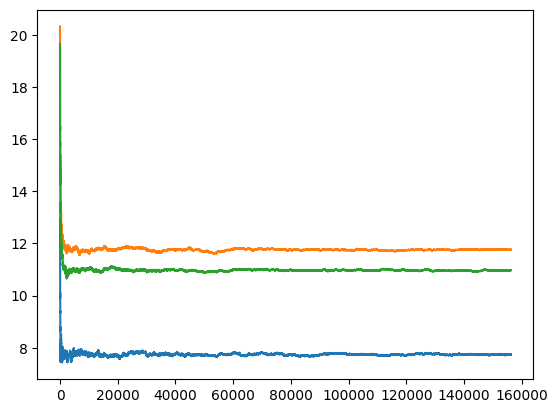

In [37]:
# we define our risk budgeting problem for expected shortfall
rb = RiskBudgeting(risk_measure='expected_shortfall',
                   alpha=0.95,
                   budgets='ERC')

rb.solve(X, 
         epochs=10,
         minibatch_size=64,
         eta_0_y=50, 
         eta_0_t=1,
         c=0.65,
         polyak_ruppert=0.2,
         store=True)

print('==== True Risk Budgeting portfolio ====')
print(np.round(SM_theta, 4))
print('==== Risk Budgeting portfolio from SGD ====')
print(np.round(rb.x, 4))

plt.plot(rb.ys);

#### Deterministic case

$$
    y^{k+1}_i =\left\{
                \begin{array}{ll}
                  y^k_i \exp(-\gamma_{k+1} \underline{y}^k \wedge 1 \partial_{y_i}  \Lambda(y^k)) , \quad \text{ if } \|y^k \exp(-\gamma_{k+1} \underline{y}^k \wedge 1 \partial_{y_i}  \Lambda(y^k))\|_1 \leq m\\
                   \frac{M}{ \|y^k \exp(-\gamma_{k+1} \underline{y}^k \wedge 1 \partial_{y_i}  \Lambda(y^k))\|_1 } \, y^k_i \exp(-\gamma_{k+1} \underline{y}^k \wedge 1 \partial_{y_i}  \Lambda(y^k)), \, \text{ otherwise }
                \end{array}
              \right.
$$

In [8]:
#### Implement Mirror Descent (positive orthant)
gamma_star = optim_res.fun

# choose risk budgets (equal)
d = nb_asset
budgets = np.ones(d)/d

# choose mirror descent parameters
n_iter = 100
M = 100
stepsize = 1

# initialize y
y = budgets

# store values
f_values_list = [StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y, alpha) - budgets@np.log(y)]
y_list = [y]

for _ in range(n_iter):

    Gamma_grad = StudentMixtureExpectedShortfall(SM_model).expected_shortfall_gradient(y, alpha) - budgets/y
    y_min = min(y)
    y = y*np.exp(-stepsize*y_min*Gamma_grad)
    sum_y = sum(y) 
    if sum_y>M:
        y = M/sum_y*y

    f_value = StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y, alpha) - budgets@np.log(y)
    y_list.append(y)
    f_values_list.append(f_value)

print('==== True Risk Budgeting portfolio ====')
print(np.round(SM_theta, 4))
print('==== MD Risk Budgeting portfolio ====')
print(np.round(y/sum(y), 4))

==== True Risk Budgeting portfolio ====
[0.2535 0.3866 0.3599]
==== MD Risk Budgeting portfolio ====
[0.2535 0.3866 0.3599]


Text(0.5, 0.98, '$M=100$')

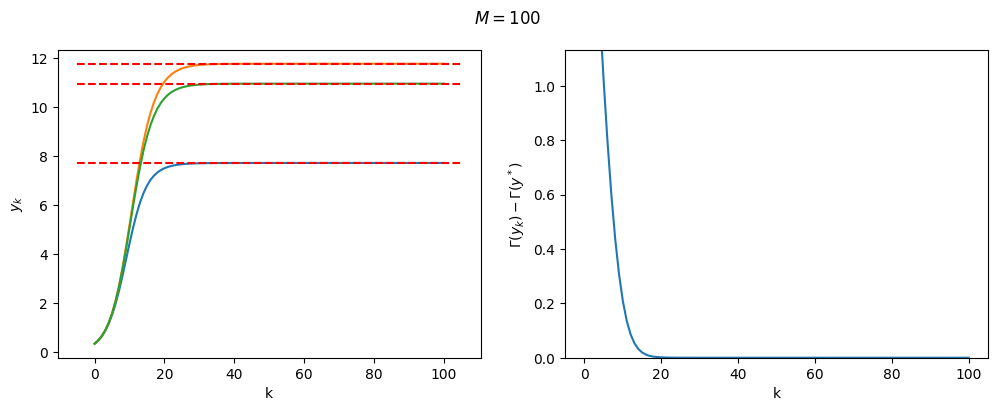

In [9]:
# plot convergence
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(y_list)
ax[0].hlines(optim_res.x, xmin=ax[0].get_xlim()[0], xmax=ax[0].get_xlim()[1], color='red', ls='dashed')
ax[0].set_ylabel('$y_k$')
ax[0].set_xlabel('k')

ax[1].plot(np.array(f_values_list) - gamma_star)
ax[1].set_ylim(0, f_values_list[0])
ax[1].set_ylabel('$\Gamma(y_k) - \Gamma(y^*)$')
ax[1].set_xlabel('k')

fig.suptitle('$M='+str(M)+'$')

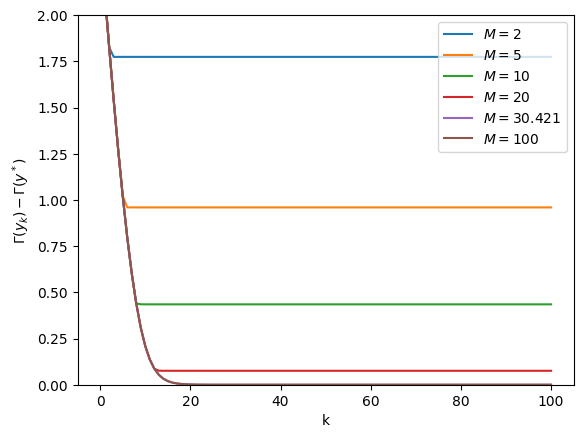

In [10]:
### different values of M

#### Implement Mirror Descent (positive orthant)
gamma_star = optim_res.fun

# choose risk budgets (equal)
d = nb_asset
budgets = np.ones(d)/d

# choose mirror descent parameters
n_iter = 100

for M in [2, 5, 10, 20, np.round(sum(optim_res.x),3),100]:

    stepsize = 1

    # initialize y
    y = budgets

    # store values
    f_values_list = [StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y, alpha) - budgets@np.log(y)]
    y_list = [y]

    for _ in range(n_iter):

        Gamma_grad = StudentMixtureExpectedShortfall(SM_model).expected_shortfall_gradient(y, alpha) - budgets/y
        y_min = min(y)
        y = y*np.exp(-stepsize*y_min*Gamma_grad)
        sum_y = sum(y) 
        if sum_y>M:
            y = M/sum_y*y

        f_value = StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y, alpha) - budgets@np.log(y)
        y_list.append(y)
        f_values_list.append(f_value)

    plt.plot(np.array(f_values_list) - gamma_star, label='$M='+str(M)+'$')
plt.ylim(0, 2)
plt.ylabel('$\Gamma(y_k) - \Gamma(y^*)$')
plt.xlabel('k')
plt.legend()

In [23]:
def learning_rate_scheme(n, delta=.1):
    return n**(-.5)*np.log(n)**(.5+delta)

def risk_budgeting_expected_shortfall_md(SM_model, budgets, alpha, learning_rate_scheme, y_init, tol):

    n = 2
    y = y_init
    gamma = learning_rate_scheme(n)
    f_value_prev = 0
    f_value = np.inf

    nominator = 0
    denominator = 0

    while abs(f_value-f_value_prev)>tol:

        f_value_prev = f_value
        
        f_grad = StudentMixtureExpectedShortfall(SM_model).expected_shortfall_gradient(y, alpha) - budgets/y
        y_min = min(y)
        y = y*np.exp(-gamma*y_min*f_grad)

        nominator+=gamma*y
        denominator+=gamma
        
        if denominator==0:
            y_mean = nominator
        else:
            y_mean = nominator/denominator

        f_value = StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_mean, alpha) - budgets@np.log(y_mean)

        n+=1
        gamma = learning_rate_scheme(n)
        

    return y_mean, n

In [24]:
y, n = risk_budgeting_expected_shortfall_md(SM_model, budgets, alpha, learning_rate_scheme, y_init=np.ones(3), tol=1e-06)